In [11]:
def embed(text):
    response = genai.embed_content(
        model="text-embedding-004",
        content=text
    )
    return response["embedding"]


In [10]:
data = [
    {
        "name": "Boho Dress",
        "desc": "A flowy dress with earthy tones, relaxed silhouette, perfect for festivals and carefree boho vibes.",
        "vibes": ["boho", "festival", "earthy"]
    },
    {
        "name": "Urban Street Jacket",
        "desc": "Sleek black jacket with sharp lines, lightweight, ideal for energetic city movement and street style.",
        "vibes": ["urban", "chic", "energetic"]
    },
    {
        "name": "Cozy Knit Sweater",
        "desc": "Soft oversized sweater, warm neutral colors, designed for comfort and cozy winter days.",
        "vibes": ["cozy", "warm", "minimal"]
    },
    {
        "name": "Sporty Running Shoes",
        "desc": "Breathable lightweight running shoes built for performance and an active sporty lifestyle.",
        "vibes": ["sporty", "active"]
    },
    {
        "name": "Elegant Evening Gown",
        "desc": "Luxurious long gown with silky texture, minimal shimmer, suited for classy elegant events.",
        "vibes": ["elegant", "classy"]
    },
    {
        "name": "Vintage Denim Jacket",
        "desc": "Retro-style denim jacket with faded wash, relaxed fit, timeless vintage energy.",
        "vibes": ["vintage", "retro"]
    }
]

df = pd.DataFrame(data)
df


,name,desc,vibes
0,Boho Dress,"A flowy dress with earthy tones, relaxed silho...","[boho, festival, earthy]"
1,Urban Street Jacket,"Sleek black jacket with sharp lines, lightweig...","[urban, chic, energetic]"
2,Cozy Knit Sweater,"Soft oversized sweater, warm neutral colors, d...","[cozy, warm, minimal]"
3,Sporty Running Shoes,Breathable lightweight running shoes built for...,"[sporty, active]"
4,Elegant Evening Gown,"Luxurious long gown with silky texture, minima...","[elegant, classy]"
5,Vintage Denim Jacket,"Retro-style denim jacket with faded wash, rela...","[vintage, retro]"


In [12]:
df["embedding"] = df["desc"].apply(embed)
df.head()


,name,desc,vibes,embedding
0,Boho Dress,"A flowy dress with earthy tones, relaxed silho...","[boho, festival, earthy]","[0.0092703365, -0.0044955006, 0.023383789, -0...."
1,Urban Street Jacket,"Sleek black jacket with sharp lines, lightweig...","[urban, chic, energetic]","[-0.0050404533, -0.0237385, -0.003604043, 0.02..."
2,Cozy Knit Sweater,"Soft oversized sweater, warm neutral colors, d...","[cozy, warm, minimal]","[0.005190728, 0.02315787, 0.034778174, -0.0219..."
3,Sporty Running Shoes,Breathable lightweight running shoes built for...,"[sporty, active]","[-0.011672067, -0.06182208, 0.013458784, -0.00..."
4,Elegant Evening Gown,"Luxurious long gown with silky texture, minima...","[elegant, classy]","[0.052740015, -0.008346754, 0.01410616, 0.0185..."


In [ ]:
def vibe_match(query, top_k=3, threshold=0.3):
    query_emb = embed(query)

    df["score"] = df["embedding"].apply(
        lambda x: cosine_similarity([query_emb], [x])[0][0]
    )

    results = df.sort_values("score", ascending=False).head(top_k)

    if results.iloc[0]["score"] < threshold:
        return None, 

    return results[["name", "desc", "score"]], None


In [15]:
queries = [
    "energetic urban chic",
    "warm cozy winter vibe",
    "retro vintage streetwear"
]

for q in queries:
    print(f"\n🔍 Query: {q}")
    results, fallback = vibe_match(q)

    if fallback:
        print(fallback)
    else:
        display(results)



🔍 Query: energetic urban chic


,name,desc,score
1,Urban Street Jacket,"Sleek black jacket with sharp lines, lightweig...",0.581002
0,Boho Dress,"A flowy dress with earthy tones, relaxed silho...",0.493345
5,Vintage Denim Jacket,"Retro-style denim jacket with faded wash, rela...",0.488911



🔍 Query: warm cozy winter vibe


,name,desc,score
2,Cozy Knit Sweater,"Soft oversized sweater, warm neutral colors, d...",0.591569
5,Vintage Denim Jacket,"Retro-style denim jacket with faded wash, rela...",0.436116
0,Boho Dress,"A flowy dress with earthy tones, relaxed silho...",0.405367



🔍 Query: retro vintage streetwear


,name,desc,score
5,Vintage Denim Jacket,"Retro-style denim jacket with faded wash, rela...",0.630625
1,Urban Street Jacket,"Sleek black jacket with sharp lines, lightweig...",0.503970
2,Cozy Knit Sweater,"Soft oversized sweater, warm neutral colors, d...",0.413132


In [16]:
eval_rows = []

for q in queries:
    results, fallback = vibe_match(q)

    if fallback:
        eval_rows.append({"query": q, "best_score": 0, "quality": "poor"})
        continue

    best_score = float(results["score"].max())
    quality = "good" if best_score >= 0.7 else "ok"

    eval_rows.append({"query": q, "best_score": best_score, "quality": quality})

pd.DataFrame(eval_rows)


,query,best_score,quality
0,energetic urban chic,0.581002,ok
1,warm cozy winter vibe,0.591569,ok
2,retro vintage streetwear,0.630625,ok


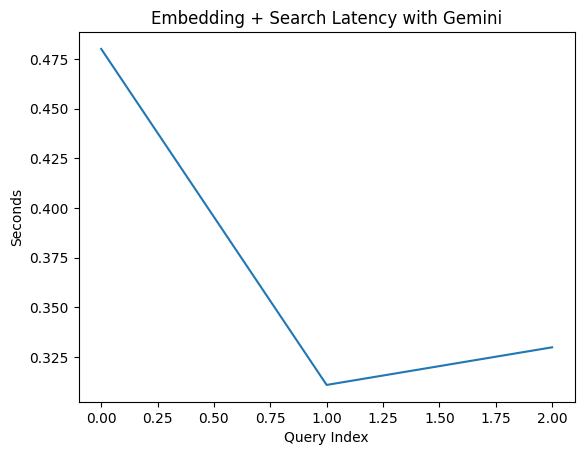

In [17]:
latencies = []

for q in queries:
    start = time.time()
    _ = vibe_match(q)
    latencies.append(time.time() - start)

plt.plot(latencies)
plt.xlabel("Query Index")
plt.ylabel("Seconds")
plt.title("Embedding + Search Latency with Gemini")
plt.show()
